                                    ## Ettore Bartalucci, begin 16.07.2022 ##
                          ## Current update 10.08.2022, running three-point average fit ##

# Mechanochemistry: Kinetics of In-situ Product Formation

This script plots the time dependence of the S/N for some representative educts and products peaks for the in-situ mechanochemical bromination reaction, which has been induced and followed by $^{13}$C-detected $^1$H-$^{13}$C CP-MAS real-time solid-state NMR. Subsequently, it computes rate constants [$s^{-1}$] with a linear regression model and fits product formation and educt consumption assuming first-order monoexponential kinetics.

We begin by assuming almost no product $\textbf{P}$ formation at time t=0s. Here we indeed would have already some products, since the rotor packing and spinning up processes introduce a non-zero pressure factor. Therefore, for further simulations we assume that at t=0s, $\textbf{[P]}$=0.01, so we only have 1% of products resulting from every other event and thus not formed in-situ. Consequently, at t=0s we assume 99% of educts present.
From here we have irreversible product formation and educts consumption with time constant $k$ [$s^{-1}$]
$$
\textbf{E} \Rightarrow \textbf{P}
$$
Textbooks reaction kinetic equations provide the following solutions when assuming first-order mechanisms:

$$
\textbf{E} = E_0 * exp^{(-kt)}
$$

and 

$$
\textbf{P} = E_0 * ( 1 - exp^{(-kt)})
$$

which we use to fit our experimental data.

## Preliminary Set-up
To run this notebook, Python 3 is required and the following modules are needed inside the active environment:
- numpy
- matplotlib
- pandas
- scipy
- lmfit

We further take into account that from the whole block of in-situ experiments we extract intensities data every second spectrum, to avoid overcrowding in the plots.

## Code Section

In [1]:
############### IMPORT MODULES #################

import numpy as np # package for mathematical computation
import matplotlib.pyplot as plt # package for plotting
#plt.style.use('seaborn-whitegrid')
%matplotlib inline
import pandas as pd # package for data parsing
import scipy as sp # Scientific python packages
import scipy.stats
import scipy.optimize
from scipy.optimize import curve_fit
from scipy.stats import linregress
#from lmfit import Model
import itertools # in case of need of plotting iterative markers in for-loop 

In [2]:
############### READING LEEROY'S DATA ###################

data = pd.read_excel('mechano_in-situ_complete_Leeroy_v2.xlsx') # change path according to the running machine AND/OR put code and table in same folder
print(data)

# remember to scale up the first datapoints by sqrt(2) since at the beginnign we have different number of scans to have shorter time window to follow the kinetics


           time  S/N peak1 in-situ products  S/N peak2 in-situ products  \
0     35.300000                        1.55                        1.06   
1    141.200000                        3.43                        3.88   
2    247.100000                        3.74                        4.09   
3    353.000000                        3.58                        4.51   
4    458.900000                        4.28                        4.30   
5    564.800000                        6.03                        4.04   
6    670.700000                        6.36                        6.50   
7    914.550000                        7.31                        5.73   
8   1123.100000                        8.20                        7.68   
9   1331.650000                        7.78                        6.40   
10  1540.200000                        8.44                        7.78   
11  1748.750000                       12.29                       11.24   
12  1957.300000          

In [3]:
############### ASSIGN VARIABLES FOR PRODUCTS FORMATION ###################

# Set iteration cycles for markers in case we use for loops
#marker = itertools.cycle(('o', 'v', 's', '8', 'p', '^', '<', '>'))

# For the products formation we choose three representative peaks, C(1), CH(2) and CH3(8) for the sulfoximine. 
# Since the number of scans differ during aquisition, we scale up the first exp by sqrt(2).

## TIME
t = data.loc[:,"time"]
t = t/60 # time in hours

## PRODUCTS S/N
products1 = data.loc[:,"S/N peak1 in-situ products"] # insert here original s/n (scale up to same NS) for in situ product formation
products1[0:6] *= np.sqrt(2) # here scale them up
products1 = products1/products1[31] # normalize
products2 = data.loc[:,"S/N peak2 in-situ products"] # insert here original s/n (scale up to same NS) for in situ product formation
products2[0:6] *= np.sqrt(2) # here scale them up
products2 = products2/products2[31] # normalize
products8 = data.loc[:,"S/N peak8 in-situ products"] # insert here original s/n (scale up to same NS) for in situ product formation
products8[0:6] *= np.sqrt(2) # here scale them up
products8 = products8/products8[31] # normalize

# Errorbars as standard deviation on the intenisty values. Eventually needs to be changed according to what we want to show
products1_error = np.std(products1)
products2_error = np.std(products2)
products8_error = np.std(products8)

print(products1_error)


0.2520658185079045


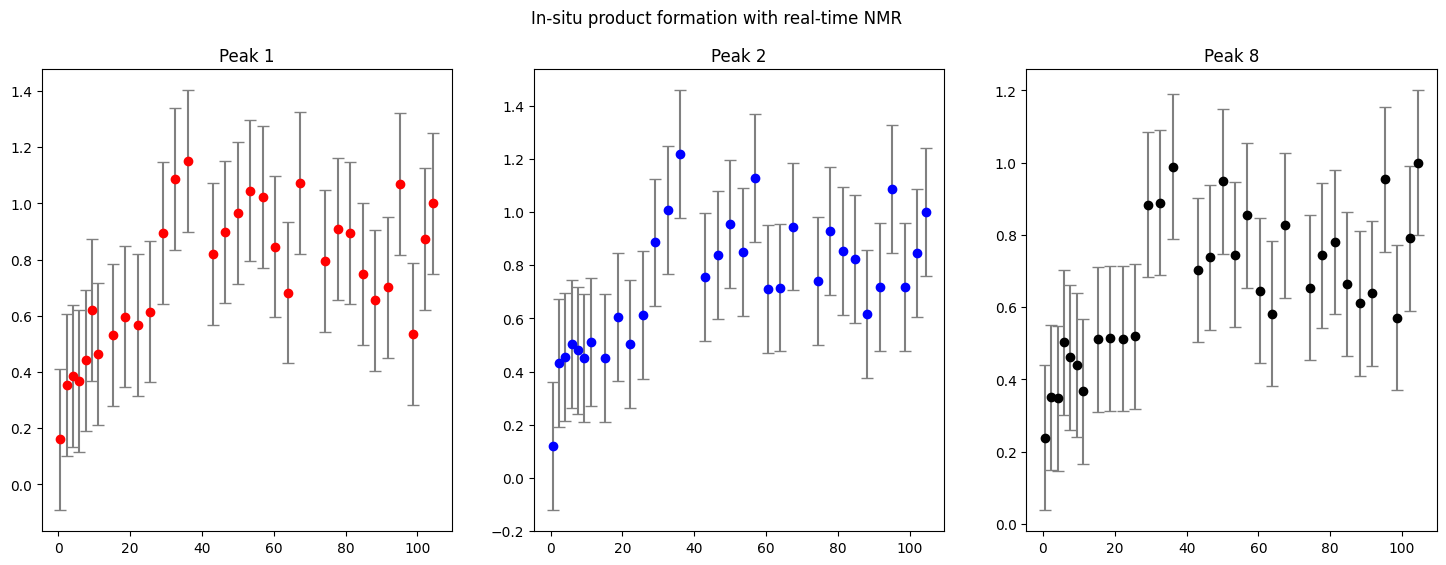

In [4]:
############### PLOTTING ###############

# Plot data to see that everything is alright
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True,figsize=(18, 6))

ax0.set_title('Peak 1')
ax0.errorbar(t, products1, yerr=products1_error, fmt='o', color='red', ecolor='gray', elinewidth=1.5, capsize=4)

ax1.set_title('Peak 2')
ax1.errorbar(t, products2, yerr=products2_error, fmt='o', color='blue', ecolor='gray', elinewidth=1.5, capsize=4)

ax2.set_title('Peak 8')
ax2.errorbar(t, products8, yerr=products8_error, fmt='o', color='black', ecolor='gray', elinewidth=1.5, capsize=4)

fig.suptitle('In-situ product formation with real-time NMR')

plt.show()



In [5]:
############### ASSIGN VARS FOR EDUCTS CONSUMPTION ###################

# For the educts we choose two representative peaks, namely C(1) and CH3(8) from the sulfoximine. We also plot C(9) but we will omit it 
# from further analysis

## TIME was defined above

## EDUCTS S/N
educts1 = data.loc[:,"S/N peak1 in-situ educts"] # insert here original s/n (scale up to same NS) for in situ product formation
educts1[0:6] *= np.sqrt(2) # scale up
educts1 = educts1/educts1[0] # normalize
educts8 = data.loc[:,"S/N peak8 in-situ educts"] # insert here original s/n (scale up to same NS) for in situ product formation
educts8[0:6] *= np.sqrt(2) # scale up
educts8 = educts8/educts8[0] # normalize
educts9 = data.loc[:,"S/N peak9 in-situ educts"] # insert here original s/n (scale up to same NS) for in situ product formation
educts9[0:6] *= np.sqrt(2) # scale up
educts9 = educts9/educts9[0] # normalize

# Errorbars as standard deviation on the intenisty values. Eventually needs to be changed according to what we want to show
educts1_error = np.std(educts1)
educts8_error = np.std(educts8)
educts9_error = np.std(educts9)



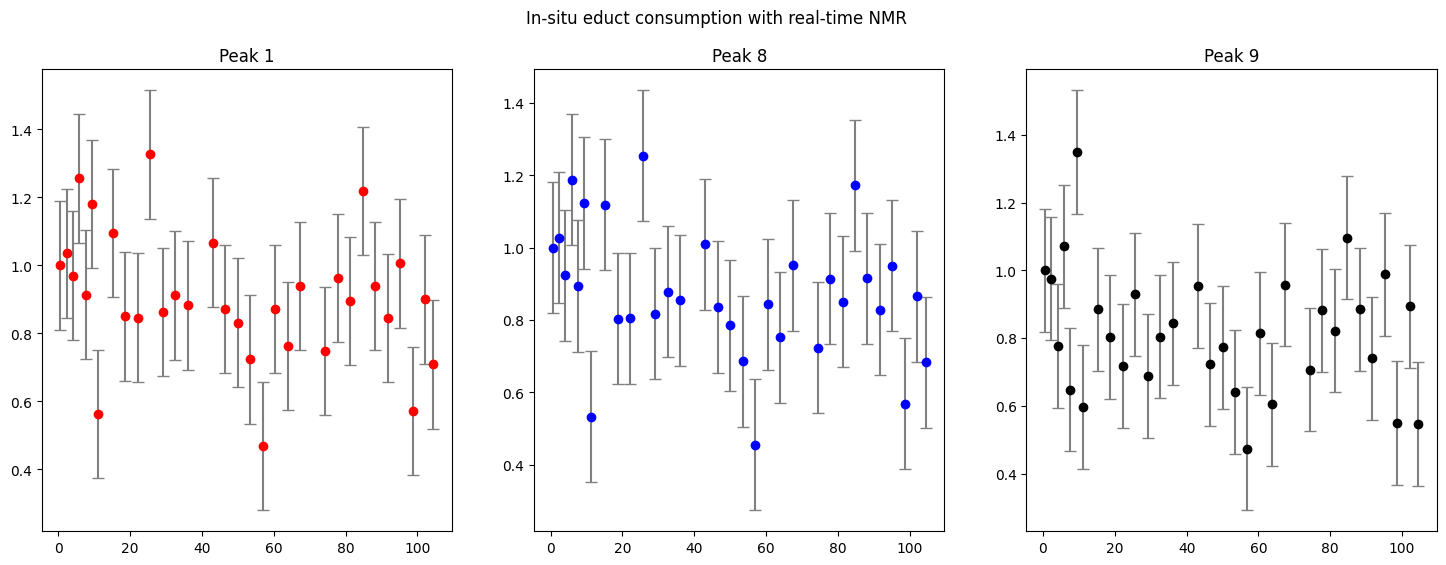

In [6]:
############### PLOTTING ###############

# Plot data to see that everything is alright
fig, (ax10, ax11, ax12) = plt.subplots(nrows=1, ncols=3, sharex=True,figsize=(18, 6))

ax10.set_title('Peak 1')
ax10.errorbar(t, educts1, yerr=educts1_error, fmt='o', color='red', ecolor='gray', elinewidth=1.5, capsize=4)

ax11.set_title('Peak 8')
ax11.errorbar(t, educts8, yerr=educts8_error, fmt='o', color='blue', ecolor='gray', elinewidth=1.5, capsize=4)

ax12.set_title('Peak 9')
ax12.errorbar(t, educts9, yerr=educts9_error, fmt='o', color='black', ecolor='gray', elinewidth=1.5, capsize=4)

fig.suptitle('In-situ educt consumption with real-time NMR')
plt.show()


[0.04133408 0.18143997]
Slope Products 1 is: 0.04133407607560429
Intercept Products 1 is: 0.1814399749718562


(-0.2, 1.5)

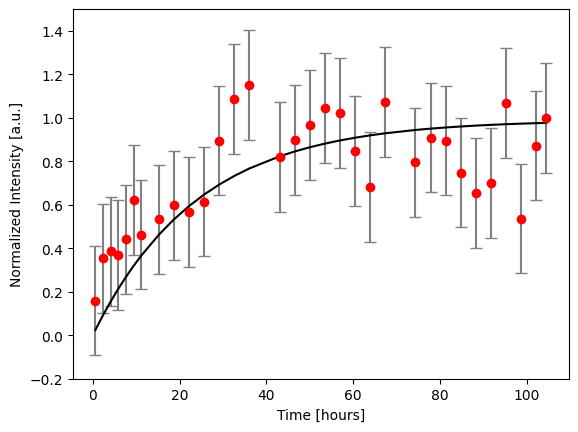

In [7]:
############### LINEAR INITIAL RATE APPROXIMATION PRODUCTS1 ###################
#
# Here we assume that at the beginning of the reaction, product formation follows a linear kinetic model of the type y = ax+b.
# For this, we fit the linear regression model on the first datapoints (circa 10h) and compute slopes (a) and intercept (b).
# We then use our initial guesses for the slopes to set up a monoexponential kinetic model for the conversion plateau due to 
# the absence of efficient mixing. We consider here that solid-state diffusion does not contribute to product formation, so only
# pure monoexponential curves are considered.
# Future implementation could be the effect of diffusion during spinning, modelled with Fick's diffusion laws.
#
################################################################################################################################
# Function 'linear_model':
#
# Inputs:
#       t = time
#       a = slope
#       b = intercept
#
# Outputs:
#       popt: best fit parameters for a and b, so slope and intercept
#       pconv: covariance matrix for uncertainties and correlations between a and b
#
################################################################################################################################

# Linear model function 
def linear_model_p1(t, a_p1, b_p1): # linear initial rate approx to find the slopes for monoexponential fit
    return a_p1 * t + b_p1

# Fit on the first datapoints
popt_p1, pcov_p1 = curve_fit(linear_model_p1, t[0:6], products1[0:6])

# Print Slope and Intercept values
print(popt_p1)
a_p1 = popt_p1[0] # Slope
b_p1 = popt_p1[1] # Intercept
print("Slope Products 1 is:", a_p1)
print("Intercept Products 1 is:", b_p1)

# Plot original data with errorbar as std
plt.errorbar(t,products1,yerr=products1_error, fmt='o', color='red', ecolor='gray', elinewidth=1.5, capsize=4)

# Set counter and make array
tstart_p1 = 0
tstop_p1 = 15
increment_p1 = 0.1
tmodel_p1 = np.arange(tstart_p1,tstop_p1,increment_p1) # Rearrange array

# define y as pmodel
pmodel_p1 = a_p1*tmodel_p1 + b_p1 # Linear model for Products

# Plot linear model fit
#plt.plot(tmodel_p1,pmodel_p1, color='blue',lw=2.5)

# Monoexp fit
educts = 0.99 # assume almost only educts ad the beginning
p1 = educts * (1 - np.exp(- a_p1 * t )) 
plt.plot(t,p1,'black')

# Styling
plt.xlabel('Time [hours]')
plt.ylabel('Normalized Intensity [a.u.]')
plt.ylim([-0.2,1.5])

# Saving
#plt.savefig("products1_fit.pdf", format="pdf", papertype='a4')



[0.02418719 0.26908659]
Slope Products 8 is: 0.024187187156069778
Intercept Products 8 is: 0.2690865857448327


(-0.2, 1.5)

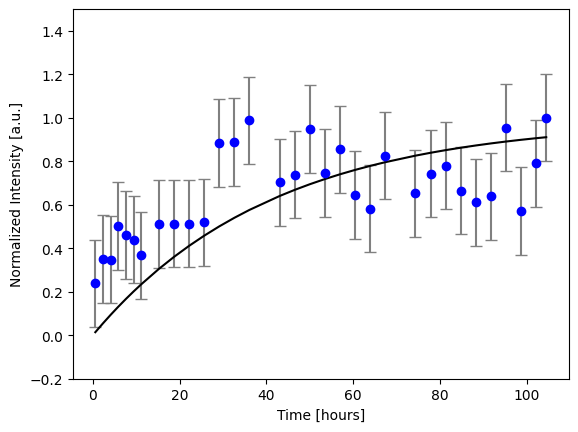

In [8]:
############### LINEAR INITIAL RATE APPROXIMATION PRODUCTS8 ###################
#
# Here we assume that at the beginning of the reaction, product formation follows a linear kinetic model of the type y = ax+b.
# For this, we fit the linear regression model on the first datapoints (circa 10h) and compute slopes (a) and intercept (b).
# We then use our initial guesses for the slopes to set up a monoexponential kinetic model for the conversion plateau due to 
# the absence of efficient mixing. We consider here that solid-state diffusion does not contribute to product formation, so only
# pure monoexponential curves are considered.
# Future implementation could be the effect of diffusion during spinning, modelled with Fick's diffusion laws.
#
################################################################################################################################
# Function 'linear_model':
#
# Inputs:
#       t = time
#       a = slope
#       b = intercept
#
# Outputs:
#       popt: best fit parameters for a and b, so slope and intercept
#       pconv: covariance matrix for uncertainties and correlations between a and b
#
################################################################################################################################

# Linear model function
def linear_model_p8(t, a_p8, b_p8): # linear initial rate approx to find the slopes for monoexponential fit
    return a_p8 * t + b_p8

# Fit on the first 20 datapoints
popt_p8, pcov_p8 = curve_fit(linear_model_p8, t[0:6], products8[0:6])

# Print Slope and Intercept values
print(popt_p8)
a_p8 = popt_p8[0] # Slope
b_p8 = popt_p8[1] # Intercept
print("Slope Products 8 is:", a_p8)
print("Intercept Products 8 is:", b_p8)

# Plot original data with errorbar as std
plt.errorbar(t,products8,yerr=products8_error, fmt='o', color='blue', ecolor='gray', elinewidth=1.5, capsize=4)

# Set counter and make array
tstart_p8 = 0
tstop_p8 = 15
increment_p8 = 0.1
tmodel_p8 = np.arange(tstart_p8,tstop_p8,increment_p8) # Rearrange array

# define y as pmodel
pmodel_p8 = a_p8*tmodel_p8 + b_p8 # Linear model for Products

# Plot linear model fit
#plt.plot(tmodel_p8,pmodel_p8, color='blue',lw=2.5)

# Monoexp fit
educts = 0.99 # assume almost only educts ad the beginning
p8 = educts * (1 - np.exp(- a_p8 * t )) 
plt.plot(t,p8,'black')

# Styling
plt.xlabel('Time [hours]')
plt.ylabel('Normalized Intensity [a.u.]')
plt.ylim([-0.2,1.5])

# Saving
#plt.savefig("products8_fit.pdf", format="pdf", papertype='a4')



[0.0299106  0.25681808]
Slope Products 2 is: 0.02991060161957318
Intercept Products 2 is: 0.25681808353663066


(-0.2, 1.5)

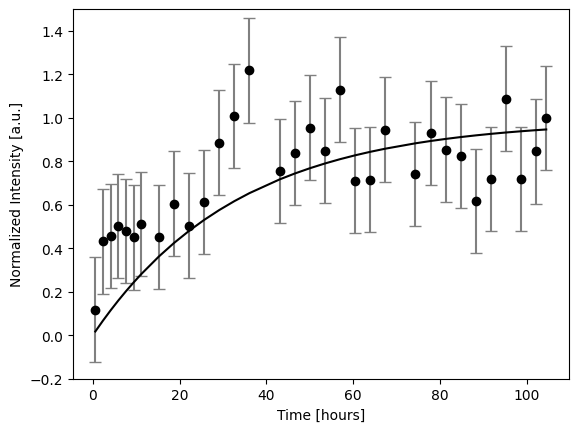

In [9]:
############### LINEAR INITIAL RATE APPROXIMATION PRODUCTS8 ###################
#
# Here we assume that at the beginning of the reaction, product formation follows a linear kinetic model of the type y = ax+b.
# For this, we fit the linear regression model on the first datapoints (circa 10h) and compute slopes (a) and intercept (b).
# We then use our initial guesses for the slopes to set up a monoexponential kinetic model for the conversion plateau due to 
# the absence of efficient mixing. We consider here that solid-state diffusion does not contribute to product formation, so only
# pure monoexponential curves are considered.
# Future implementation could be the effect of diffusion during spinning, modelled with Fick's diffusion laws.
#
################################################################################################################################
# Function 'linear_model':
#
# Inputs:
#       t = time
#       a = slope
#       b = intercept
#
# Outputs:
#       popt: best fit parameters for a and b, so slope and intercept
#       pconv: covariance matrix for uncertainties and correlations between a and b
#
################################################################################################################################

# Linear model function
def linear_model_p2(t, a_p2, b_p2): # linear initial rate approx to find the slopes for monoexponential fit
    return a_p2 * t + b_p2

# Fit on the first 20 datapoints
popt_p2, pcov_p2 = curve_fit(linear_model_p2, t[0:6], products2[0:6])

# Print Slope and Intercept values
print(popt_p2)
a_p2 = popt_p2[0] # Slope
b_p2 = popt_p2[1] # Intercept
print("Slope Products 2 is:", a_p2)
print("Intercept Products 2 is:", b_p2)

# Plot original data with errorbar as std
plt.errorbar(t,products2,yerr=products2_error, fmt='o', color='black', ecolor='gray', elinewidth=1.5, capsize=4)

# Set counter and make array
tstart_p2 = 0
tstop_p2 = 15
increment_p2 = 0.1
tmodel_p2 = np.arange(tstart_p2,tstop_p2,increment_p2) # Rearrange array

# define y as pmodel
pmodel_p2 = a_p2*tmodel_p2 + b_p2 # Linear model for Products

# Plot linear model fit
#plt.plot(tmodel_p2,pmodel_p2, color='blue',lw=2.5)

# Monoexp fit
educts = 0.99 # assume almost only educts ad the beginning
p2 = educts * (1 - np.exp(- a_p2 * t )) 
plt.plot(t,p2,'black')

# Styling
plt.xlabel('Time [hours]')
plt.ylabel('Normalized Intensity [a.u.]')
plt.ylim([-0.2,1.5])

# Saving
#plt.savefig("products2_fit.pdf", format="pdf", papertype='a4')



[0.01336192 0.99259739]
Slope Educts 1 is: 0.013361917562226721
Intercept Educts 1 is: 0.9925973856486532


(0.0, 1.6)

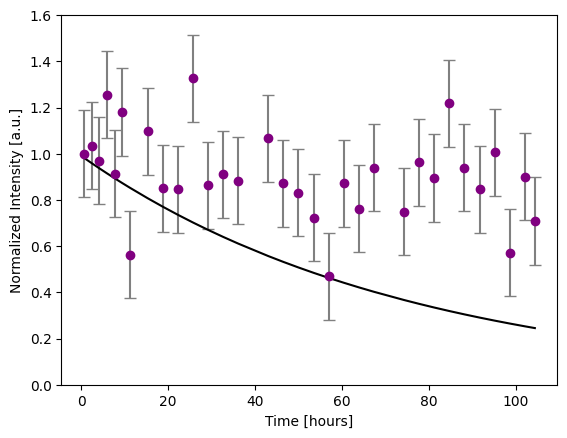

In [10]:
############### LINEAR INITIAL RATE APPROXIMATION EDUCTS1 ###################
#
# Here we assume that at the beginning of the reaction, educts consumption follows a linear kinetic model of the type y = ax+b.
# For this, we fit the linear regression model on the first datapoints (circa 10h) and compute slopes (a) and intercept (b).
# We then use our initial guesses for the slopes to set up a monoexponential kinetic model for the conversion plateau due to 
# the absence of efficient mixing. We consider here that solid-state diffusion does not contribute to product formation.
# Future implementation could be the effect of diffusion during spinning, modelled with Fick's diffusion laws.
#
################################################################################################################################
# Function 'linear_model':
#
# Inputs:
#       t = time
#       a = slope
#       b = intercept
#
# Outputs:
#       popt: best fit parameters for a and b, so slope and intercept
#       pconv: covariance matrix for uncertainties and correlations between a and b
#
################################################################################################################################

# Linear model function
def linear_model_e1(t, a_e1, b_e1): # linear initial rate approx to find the slopes for monoexponential fit
    return a_e1 * t + b_e1

# Fit on the first 20 datapoints
popt_e1, pcov_e1 = curve_fit(linear_model_e1, t[0:6], educts1[0:6])

# Print Slope and Intercept values
print(popt_e1)
a_e1 = popt_e1[0] # Slope
b_e1 = popt_e1[1] # Intercept
print("Slope Educts 1 is:", a_e1)
print("Intercept Educts 1 is:", b_e1)

# Plot original data with errorbar as std
plt.errorbar(t,educts1,yerr=educts1_error, fmt='o', color='purple', ecolor='gray', elinewidth=1.5, capsize=4)

# Set counter and make array
tstart_e1 = 0
tstop_e1 = 15
increment_e1 = 0.1
tmodel_e1 = np.arange(tstart_e1,tstop_e1,increment_e1) # Rearrange array

# define y as pmodel
pmodel_e1 = -a_e1*tmodel_e1 + b_e1 # Linear model for Products

# Plot linear model fit
#plt.plot(tmodel_e1,pmodel_e1, color='blue',lw=2.5)

# Monoexp fit
educts = 0.99 # assume almost only educts ad the beginning
e1 = educts * np.exp(- a_e1 * t )
plt.plot(t,e1,'black')

# Styling
plt.xlabel('Time [hours]')
plt.ylabel('Normalized Intensity [a.u.]')
plt.ylim([0,1.6])

# Saving
#plt.savefig("educts1_fit.pdf", format="pdf", papertype='a4')


[0.00785231 0.98700325]
Slope Educts 8 is: 0.007852309321597197
Intercept Educts 8 is: 0.987003252793023


(0.0, 1.6)

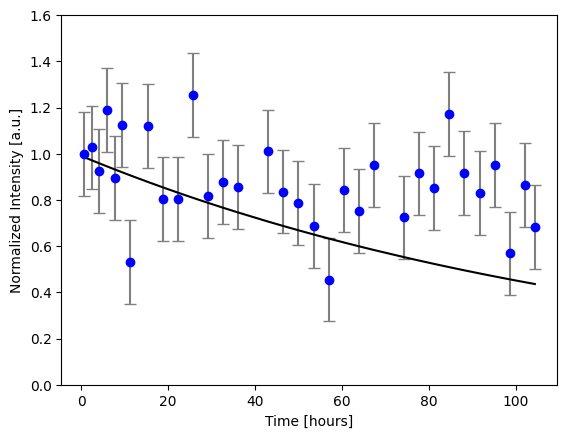

In [11]:
############### LINEAR INITIAL RATE APPROXIMATION EDUCTS8 ###################
#
# Here we assume that at the beginning of the reaction, educts consumption follows a linear kinetic model of the type y = ax+b.
# For this, we fit the linear regression model on the first 20 datapoints (circa 10h) and compute slopes (a) and intercept (b).
# We then use our initial guesses for the slopes to set up a monoexponential kinetic model for the conversion plateau due to 
# the absence of efficient mixing. We consider here that solid-state diffusion does not contribute to product formation.
# Future implementation could be the effect of diffusion during spinning, modelled with Fick's diffusion laws.
#
################################################################################################################################
# Function 'linear_model':
#
# Inputs:
#       t = time
#       a = slope
#       b = intercept
#
# Outputs:
#       popt: best fit parameters for a and b, so slope and intercept
#       pconv: covariance matrix for uncertainties and correlations between a and b
#
################################################################################################################################

# Linear model function
def linear_model_e8(t, a_e8, b_e8): # linear initial rate approx to find the slopes for monoexponential fit
    return a_e8 * t + b_e8

# Fit on the first 20 datapoints
popt_e8, pcov_e8 = curve_fit(linear_model_e8, t[0:6], educts8[0:6])

# Print Slope and Intercept values
print(popt_e8)
a_e8 = popt_e8[0] # Slope
b_e8 = popt_e8[1] # Intercept
print("Slope Educts 8 is:", a_e8)
print("Intercept Educts 8 is:", b_e8)

# Plot original data with errorbar as std
plt.errorbar(t,educts8,yerr=educts8_error, fmt='o', color='blue', ecolor='gray', elinewidth=1.5, capsize=4)

# Set counter and make array
tstart_e8 = 0
tstop_e8 = 15
increment_e8 = 0.1
tmodel_e8 = np.arange(tstart_e8,tstop_e8,increment_e8) # Rearrange array

# define y as pmodel
pmodel_e8 = -a_e8*tmodel_e8 + b_e8 # Linear model for Products

# Plot linear model fit
#plt.plot(tmodel_e8,pmodel_e8, color='blue',lw=2.5)

# Monoexp fit
educts = 0.99 # assume almost only educts ad the beginning
e8 = educts * np.exp(- a_e8 * t )
plt.plot(t,e8,'black')

# Styling
plt.xlabel('Time [hours]')
plt.ylabel('Normalized Intensity [a.u.]')
plt.ylim([0,1.6])

# Saving
#plt.savefig("educts8_fit.pdf", format="pdf", papertype='a4')



[0.01716121 0.88448403]
Slope Educts 9 is: 0.017161210690473577
Intercept Educts 9 is: 0.8844840256426578


(0.0, 1.6)

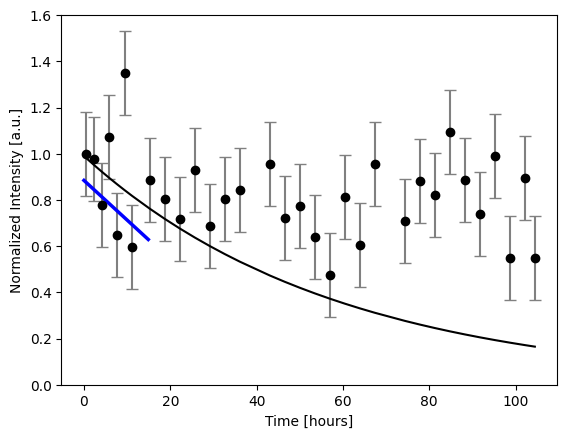

In [13]:
############### LINEAR INITIAL RATE APPROXIMATION EDUCTS9 ###################
#
# Here we assume that at the beginning of the reaction, educts consumption follows a linear kinetic model of the type y = ax+b.
# For this, we fit the linear regression model on the first 20 datapoints (circa 10h) and compute slopes (a) and intercept (b).
# We then use our initial guesses for the slopes to set up a monoexponential kinetic model for the conversion plateau due to 
# the absence of efficient mixing. We consider here that solid-state diffusion does not contribute to product formation.
# Future implementation could be the effect of diffusion during spinning, modelled with Fick's diffusion laws.
#
################################################################################################################################
# Function 'linear_model':
#
# Inputs:
#       t = time
#       a = slope
#       b = intercept
#
# Outputs:
#       popt: best fit parameters for a and b, so slope and intercept
#       pconv: covariance matrix for uncertainties and correlations between a and b
#
################################################################################################################################

# Linear model function
def linear_model_e9(t, a_e9, b_e9): # linear initial rate approx to find the slopes for monoexponential fit
    return a_e9 * t + b_e9

# Fit on the first 20 datapoints
popt_e9, pcov_e9 = curve_fit(linear_model_e9, t[0:6], educts9[0:6])

# Print Slope and Intercept values
print(popt_e9)
a_e9 = popt_e9[0] # Slope
b_e9 = popt_e9[1] # Intercept
print("Slope Educts 9 is:", a_e9)
print("Intercept Educts 9 is:", b_e9)

# Plot original data with errorbar as std
plt.errorbar(t,educts9,yerr=educts9_error, fmt='o', color='black', ecolor='gray', elinewidth=1.5, capsize=4)

# Set counter and make array
tstart_e9 = 0
tstop_e9 = 15
increment_e9 = 0.1
tmodel_e9 = np.arange(tstart_e9,tstop_e9,increment_e9) # Rearrange array

# define y as pmodel
pmodel_e9 = -a_e9*tmodel_e9 + b_e9 # Linear model for Products

# Plot linear model fit
plt.plot(tmodel_e9,pmodel_e9, color='blue',lw=2.5)

# Monoexp fit
educts = 0.99 # assume almost only educts ad the beginning
e9 = educts * np.exp(- a_e9 * t )
plt.plot(t,e9,'black')

# Styling
plt.xlabel('Time [hours]')
plt.ylabel('Normalized Intensity [a.u.]')
plt.ylim([0,1.6])

# Saving
#plt.savefig("educts9_fit.pdf", format="pdf", papertype='a4')


## Test Three-point average fit

In [14]:
############### ASSIGN VARIABLES FOR AVERAGE PRODUCTS FORMATION ###################

## TIME
t = data.loc[:,"time"]
t = t/60 # time in hours

## THREE POINT AVERAGE PRODUCTS S/N
products1 = data.loc[:,"S/N peak1 in-situ products"] # insert here original s/n (scale up to same NS) for in situ product formation
products1[0:6] *= np.sqrt(2) # here scale them up
products1 = products1/products1[31] # normalize
products2 = data.loc[:,"S/N peak2 in-situ products"] # insert here original s/n (scale up to same NS) for in situ product formation
products2[0:6] *= np.sqrt(2) # here scale them up
products2 = products2/products2[31] # normalize
products8 = data.loc[:,"S/N peak8 in-situ products"] # insert here original s/n (scale up to same NS) for in situ product formation
products8[0:6] *= np.sqrt(2) # here scale them up
products8 = products8/products8[31] # normalize

# Errorbars as standard deviation on the intenisty values. Eventually needs to be changed according to what we want to show
products1_error = np.std(products1)
products2_error = np.std(products2)
products8_error = np.std(products8)


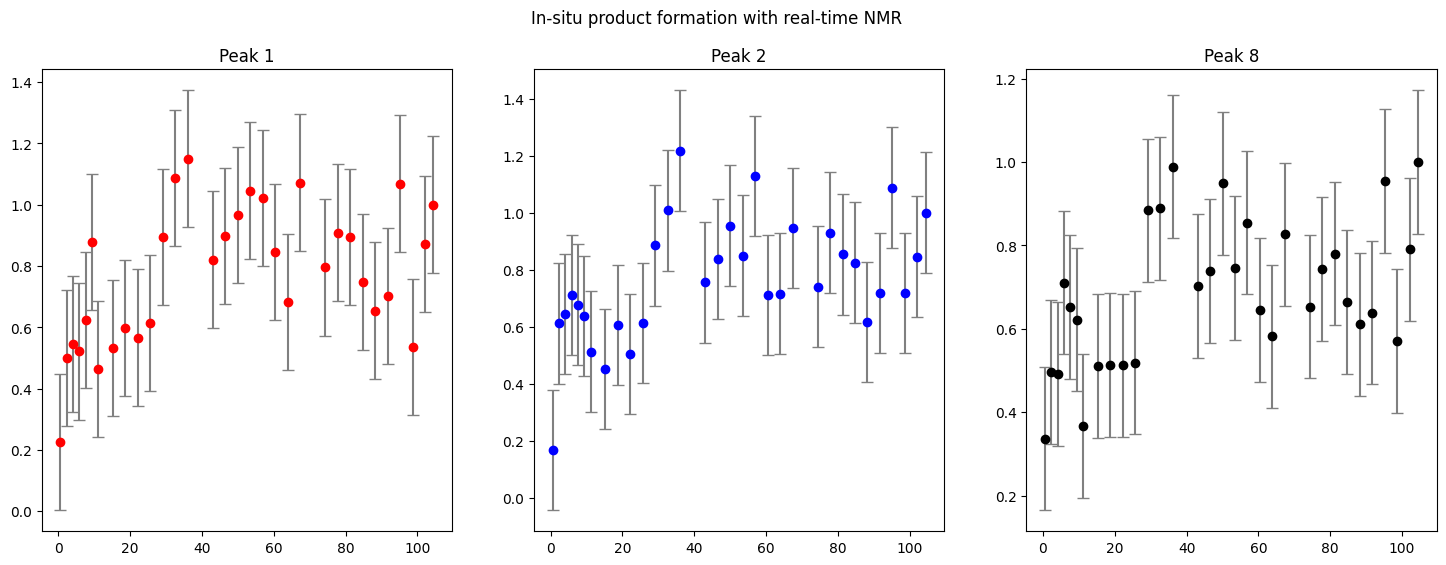

In [15]:
############### PLOTTING ###############

# Plot data to see that everything is alright
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True,figsize=(18, 6))

ax0.set_title('Peak 1')
ax0.errorbar(t, products1, yerr=products1_error, fmt='o', color='red', ecolor='gray', elinewidth=1.5, capsize=4)

ax1.set_title('Peak 2')
ax1.errorbar(t, products2, yerr=products2_error, fmt='o', color='blue', ecolor='gray', elinewidth=1.5, capsize=4)

ax2.set_title('Peak 8')
ax2.errorbar(t, products8, yerr=products8_error, fmt='o', color='black', ecolor='gray', elinewidth=1.5, capsize=4)

fig.suptitle('In-situ product formation with real-time NMR')

plt.show()